In [37]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Load the data and apply preprocessing

### Load the data and merge the necessary information

In [38]:
# Load the datasets
sch_stat_df = pd.read_excel('Datasets/scottish_schools_stats.xlsx')
sch_info_df = pd.read_excel('Datasets/scottish_schools_contact.xlsx', sheet_name='Open Schools')
dep_df = pd.read_excel('Datasets/postcode_deprivation.xlsx')

In [39]:
# Change Seed Code name to be matched with the stat dataset
sch_info = sch_info_df.rename(columns={'Seed Code' : 'SeedCode'})

In [40]:
# Merge info and stat datasets
sch_df = sch_info.merge(sch_stat_df, on='SeedCode', how='left')

In [41]:
# Remove unnecessary columns
columns_to_remove = ['School Name_y', 'Centre Type', 'Address Line1',
       'Address Line2', 'Address Line3', 'Unique Property Reference Number (UPRN)', 'Email', 'Phone Number',
       'Website Address', 'Pre-school Department', 'Primary Department',
       'Secondary Department', 'Special Department', 'Gaelic Unit',
       'Integrated Special Unit', 'Denomination', 'Local Authority']


sch_df.drop(columns=columns_to_remove, inplace=True) # Drop the columns
sch_df = sch_df.rename(columns={'School Name_x' : 'School Name'}) # Fix the column name
sch_df = sch_df.rename(columns={'LA Name' : 'Local Authority'}) # Fix the column name

In [42]:
# Create a function to return the deprivation value
def get_dep(pos):
    try:
        dep_value = dep_df[dep_df['Postcode'] == pos]['SIMD2020v2_Quintile'].values[0]
        return dep_value
    
    except:
        return None

In [43]:
# Add the deprivaion quintile value for each school
sch_df['Deprivation Quintile'] = list(map(get_dep, sch_df['Post Code']))

In [44]:
# Drop null values
sch_df = sch_df.dropna()

In [45]:
# Group the school data by local authority
data = {
    'Pupils': sch_df.groupby('Local Authority').mean(numeric_only=True)['Total pupils'],
    'DeprivationScore': sch_df.groupby('Local Authority').mean(numeric_only=True)['Deprivation Quintile'],
}

# Create a DataFrame from the sample data
df = pd.DataFrame(data)

### Preprocessing

In [46]:
# Import standard scaler to normalize the data
from sklearn.preprocessing import StandardScaler

# Specify the numerical features
numeric_columns = ['Pupils', 'DeprivationScore']

# Create a scaler object
scaler = StandardScaler()

# Scale the numeric columns
scaled_values = scaler.fit_transform(df[numeric_columns])

# Sonvert the numpy array of scaled values into a dataframe
scaled_values = pd.DataFrame(scaled_values, columns = numeric_columns)

# Describe the scaled columns: each has 0 mean and 1 standard deviation
scaled_values.describe().round(2)

,Pupils,DeprivationScore
count,33.00,33.00
mean,0.00,-0.00
std,1.02,1.02
min,-1.75,-1.87
25%,-0.61,-0.80
50%,0.17,0.04
75%,0.83,0.87
max,2.45,1.65


## K-Means Clustering

In [47]:
# Import KMeans clutering class
from sklearn.cluster import KMeans

### Find the best k - the number of clusters to be formed

Within-Cluster Sum of Squares (WCSS) method

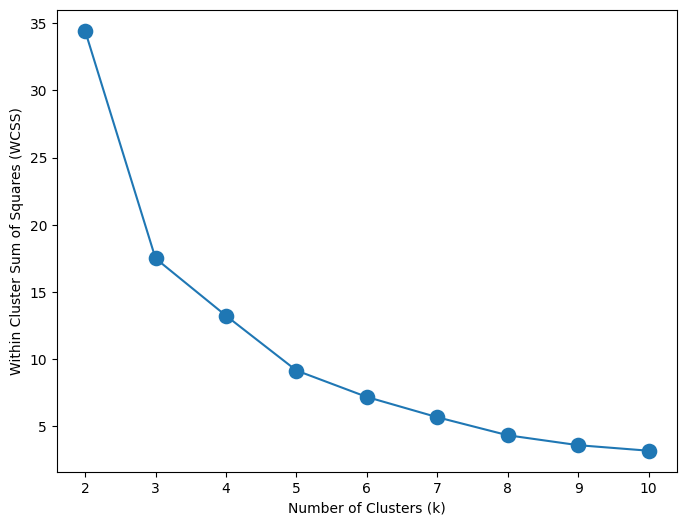

In [48]:
# Create a list to store WCSS values
wcss = []

# Iterate in a range from 2 to 10, inclusive
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234) # Create a cluster object for each k
    km.fit(scaled_values) # Fit the scaled data
    wcss.append(km.inertia_) # Add the inertia score to wcss list

# Convert the WCSS list into a pandas series object
wcss_series = pd.Series(wcss, index = range(2, 11))

# Draw a line chart showing the inertia score, or WCSS, for each k iterated
plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = wcss_series, x = wcss_series.index)
ax = sns.scatterplot(y = wcss_series, x = wcss_series.index, s = 150)
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Within Cluster Sum of Squares (WCSS)')


# Define the folder path and create it if it doesn't exist
cwd = os.getcwd()
figures_folder = os.path.join(cwd, 'figures')  # No leading forward slash before 'figures'

os.makedirs(figures_folder, exist_ok=True)

# Save the plot as a JPG image in the 'figures' folder
plt.savefig(os.path.join(figures_folder, 'wcss.jpg'), format='jpg', dpi=300)

plt.show()

Average Silhouette Method

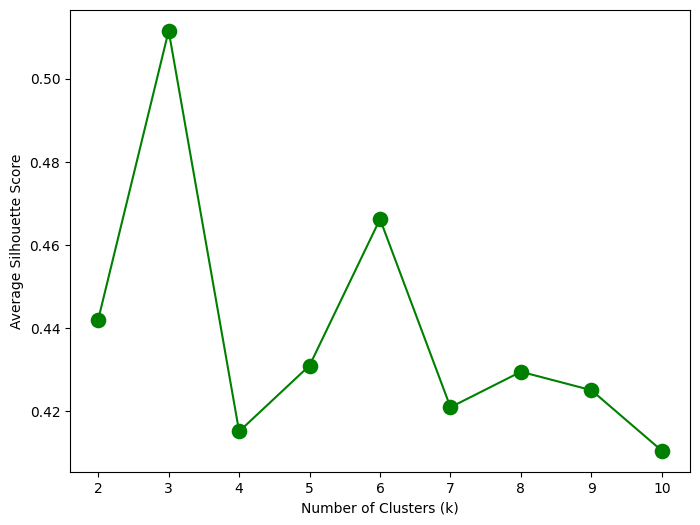

In [49]:
# Import silhouette_score function
from sklearn.metrics import silhouette_score 

# Create a list to store silhouette values
silhouette = []

# Iterate in a range from 2 to 10, inclusive
for k in range(2, 11):
    km = KMeans(n_clusters = k, n_init = 25, random_state = 1234) # Create a cluster object for each k
    km.fit(scaled_values) # Fit the scaled data
    silhouette.append(silhouette_score(scaled_values, km.labels_)) # Add the silhouette score to silhouette list

# Convert the silhouette list into a pandas series object
silhouette_series = pd.Series(silhouette, index = range(2, 11))

# Draw a line chart showing the average silhouette score for each k iterated
plt.figure(figsize=(8, 6))
ax = sns.lineplot(y = silhouette_series, x = silhouette_series.index, color='green')
ax = sns.scatterplot(y = silhouette_series, x = silhouette_series.index, s = 150, color='green')
ax = ax.set(xlabel = 'Number of Clusters (k)', 
            ylabel = 'Average Silhouette Score')

# Define the folder path and create it if it doesn't exist
os.makedirs(figures_folder, exist_ok=True)

# Save the plot as a JPG image in the 'figures' folder
plt.savefig(os.path.join(figures_folder, 'silhouette.jpg'), format='jpg', dpi=300)

plt.show()

From both methods, we can conclude that 3 is the best number of clusters

### Apply K-Means Clustering

In [50]:
# Create kmeans object
km = KMeans(n_clusters = 3, n_init = 25, random_state = 1234)

# Fit the scaled values
km.fit(scaled_values)

KMeans(n_clusters=3, n_init=25, random_state=1234)

In [51]:
# Check out how many schools each cluster possesses
for index in range(len(pd.Series(km.labels_).value_counts())):
    print('Cluster',pd.Series(km.labels_).value_counts().sort_index().index[index],'has',
          pd.Series(km.labels_).value_counts().sort_index()[index],'local authorities')

Cluster 0 has 5 local authorities
Cluster 1 has 15 local authorities
Cluster 2 has 13 local authorities


In [52]:
# Create a dataframe storing cluster centers for each column
cluster_centers = pd.DataFrame(km.cluster_centers_, columns = numeric_columns)

In [53]:
# Add the cluster indicator for every single player in the dataset
df['cluster'] = km.labels_.tolist()

In [54]:
# Group the dataframe by the cluster indicators
df.groupby('cluster').mean(numeric_only=True).round(2)

,Pupils,DeprivationScore
cluster,,
0,438.29,3.50
1,331.48,2.39
2,175.87,3.31


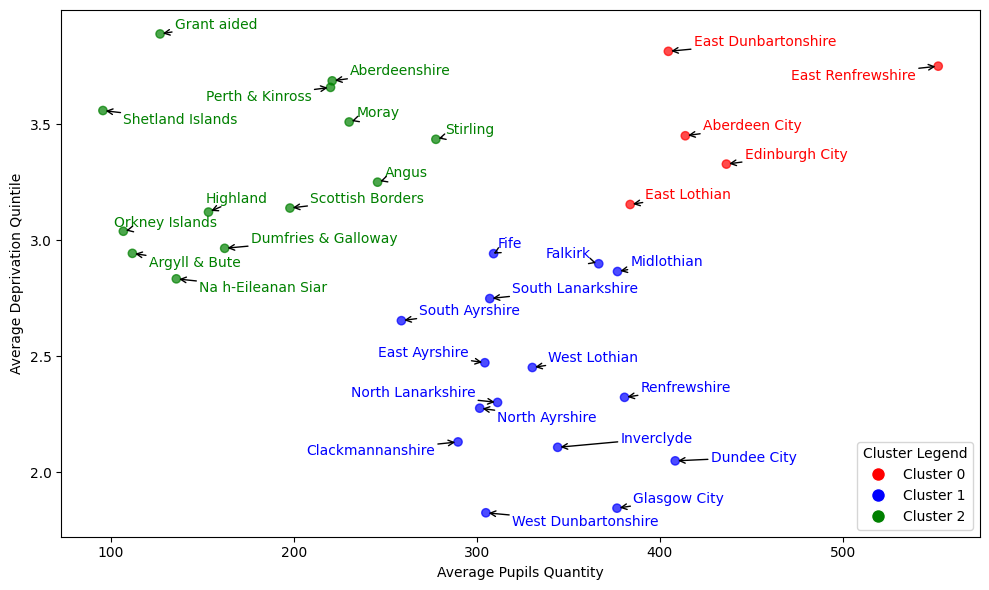

In [55]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# Sample data (replace with your actual data)
data = {
    'LocalAuthority': sch_df.groupby('Local Authority').mean(numeric_only=True).index,
    'Pupils': sch_df.groupby('Local Authority').mean(numeric_only=True)['Total pupils'],
    'DeprivationScore': sch_df.groupby('Local Authority').mean(numeric_only=True)['Deprivation Quintile'],
}

# Create a DataFrame from the sample data
df = pd.DataFrame(data)

# add the cluster feature and values
df['Cluster'] = km.labels_.tolist()

# Define custom colors for each cluster
custom_colors = ['red', 'blue', 'green']

# Create a scatter plot with custom colors
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Pupils'], df['DeprivationScore'], c=[custom_colors[i] for i in df['Cluster']], alpha=0.7)

# Set labels and title
plt.xlabel('Average Pupils Quantity')
plt.ylabel('Average Deprivation Quintile')

# Annotate and adjust labels to prevent overlap
texts = [plt.text(row['Pupils'], row['DeprivationScore'], row['LocalAuthority'], fontsize=10, color=custom_colors[row['Cluster']]) for _, row in df.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'), force_text=0.1, expand_points=(1.3, 1.3))

# Create a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {i}') for i, color in enumerate(custom_colors)]
legend = plt.legend(handles=legend_elements, title='Cluster Legend', loc='lower right')


# Define the folder path and create it if it doesn't exist
cwd = os.getcwd()
figures_folder = os.path.join(cwd, 'figures')

os.makedirs(figures_folder, exist_ok=True)

# Save the plot as a JPG image in the 'figures' folder
plt.savefig(os.path.join(figures_folder, 'Scottish Local Authorities Clustering.jpg'), format='jpg', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()